# Comparación de distribuciones espaciales de dosis
------

En el flujo de trabajo de un Servicio de Radioterapia es común tener que comparar distribuciones espaciales de dosis, normalmente la distribución calculada frente a la distribución medida.

La comparación empieza, al menos desde un punto de vista cualitativo, con una visualización de las distribuciones. 

Las distribuciones espaciales de dosis suelen ser 3D, en las tres dimensiones ortoganales del espacio, o incluso 4D, cuando se añade un cuarto eje para incorporar la evolución temporal de la distribución espacial, por ejemplo cuando se tiene en cuenta cómo varía la geometría del paciente durante la irradiación por cambios debidos a la respiración o a otros movimientos fisiológicos.

Para su visualización en el ordenador normalmente estas distribuciones se *filtran* para seleccionar una determinada región bidimensional. En la jerga del análisis de datos a este proceso se le denomina _slicing_.

En otras ocasiones la distribución espacial de dosis es ya originalmente bidimensional, un plano de dosis, o unidimensional, una curva como por ejemplo un rendimiento en profundidad o _PDD_, o un perfil de dosis o curva _OAR_ (del inglés **P**_ercentage_ **D**_epth_ **D**_ose_ y **O**_ff_ **A**_xis_ **R**_atio_)

Estas distribuciones son fácilmente almacenables en archivos `csv` o Excel.

La casa comercial Varian utiliza un formato tipo `csv` al que denominan `dxf`**D**_ata_ _e_**X**_change_ **F**_ormat_.

Los ficheros contienen un encabezado de 48 líneas con metainformación sobre la distribución. La metainformación es fácilmente interpretable por un humano. Está formada por pares **etiqueta**, **valor**.

El resto del archivo contiene la propia distribución con cada valor separado por tabulador.

Estos archivos se pueden leer fácilmente mediante pandas (python) DataFrames o importar en Excel.

`matplotlib`permite visualizar estas distribuciones de dosis pero resulta especialmente conveniente utilizar el módulo `seaborn` construido sobre `matplotlib` para representarlas de forma fácil partiendo de los pandas DataFrames en los que se hayan leído.

`seaborn`es otro de los módulos instalados por defeccto en **Colab**.

Comenzamos importando todos los módulos que nos hacen falta

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

Para poder visualizar la distribuciones primero necesitamos las propias distribuciones.

Necesitaremos:

- Montar el disco gDrive
- Elegir el directorio de trabajo
- Descargar los archivos de las distribuciones

Para montar el disco importamos el módulo `drive` en **Colab** e invocamos la función de montado. Recordemos que tendremos que dara a **Colab** la autorización para acceder a nuestro *Drive*.

In [ ]:
# - Importar el módulo para acceder a Drive
from google.colab import drive
# - Montar el disco
drive.mount('/content/gdrive')

Cambiamos al directorio que mejor nos parezca. Siempre podemos utilizar la barra lateral de navegación por archivos para conocer la ruta de la carpeta que elijamos

In [ ]:
%cd ###Reemplazar con el directorio de trabajo###

Para este tutorial hemos colocado en **GitHub** los datos de las distribuciones. Los siguientes comandos los descargan a nuestra carpeta de trabajo

In [ ]:
!wget https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Colab/Plan.Sagital.dxf
!wget https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Colab/Plan.Sagital.Med.dxf

Leemos los archivos `dxf`con las distribuciones de dosis en sendos pandas DataFrames.

In [3]:
sdf = pd.read_csv('Plan.Sagital.dxf', header=47, sep='\t', names=np.arange(160))
smdf = pd.read_csv('Plan.Sagital.Med.dxf', header=47, sep='\t', names=np.arange(160))

Definimos una función para representar las distribuciones espaciales de dosis.

Se trata de una función de conveniencia para no tener que repetir varias veces el mismo código.

Utilizamos la función `heatmap`del módulo `seaborn`para representar la distribución espacial.

In [4]:
def mapplot(ddf, ax, cmap='jet', label='Dosis [Gy]', title=None):
    sns.heatmap(ddf, cmap=cmap, ax=ax, cbar_kws={'label': label})
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_title(title)
    return  

Podemos por ejemplo representar la distribución de referencia, la de evalaución y la diferencia entre ambas

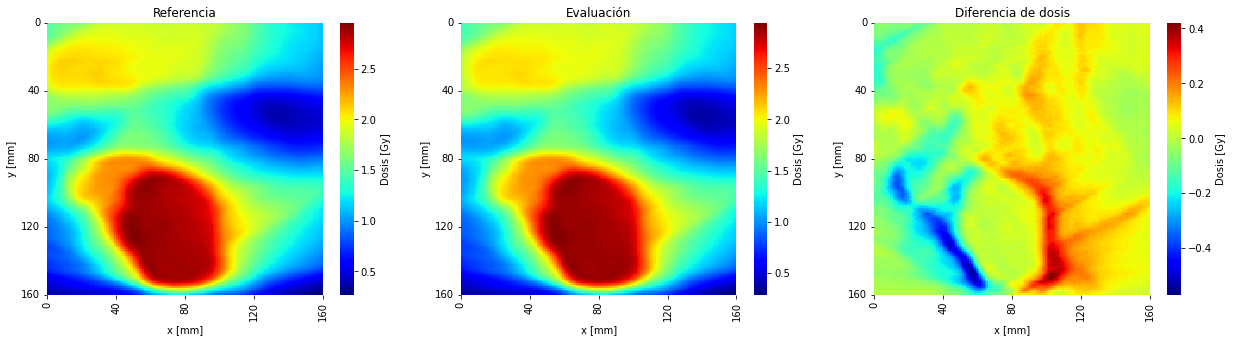

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(21, 5))
mapplot(sdf, ax1, title='Referencia')
mapplot(smdf, ax2, title='Evaluación')
mapplot(smdf-sdf, ax3, title='Diferencia de dosis')

La distribución corresponde a un plano sagital de un tratamiento de próstata con cadenas pélvicas. El paciente tendría su cabeza orientada hacia la parte superior de la imagen y sus pies en la inferior. La región de mayor valor de dosis corresponde al volumen de la próstata que recibe dosis de 2.5 Gy o superiores, la región de color anaranjado (dosis alrededor de 2.2 Gy) corresponde a las vesículas seminales, la mancha en la parte superior de la distribución de color amarillo verdoso (dosis entre 1.8 y 2 Gy) corresponde a las dosis que recibirán las cadenas ganglionares pélvicas. Los volúmenes de menor dosis (colores azulados) son las dosis que recibirán la vejiga, región en forma de C a la derecha de la imagen, y el recto, esquina inferior izquierda y entrante que rodea a las vesículas seminales y separa la región de cadenas pélvicas.

También es posible visualizar las distribucions y realizar una comparación de las mismas en términos de isodosis: curvas que unen los puntos de igual valor de dosis

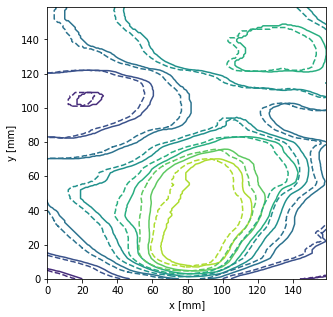

In [7]:
fig, ax = plt.subplots(figsize=(5,5))
ax.contour(np.rot90(sdf.values, k=2))
ax.contour(np.rot90(smdf.values, k=2), linestyles = 'dashed')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
plt.show()

Sobre la distribución de isodosis es más fácil comprender el concepto de distancia al acuerdo como la distancia que separa en cada punto la isodosis de igual valor.

Por último también podemos realizar una evaluación cuantitativa *slicing* la distribución y representando perfiles de dosis.

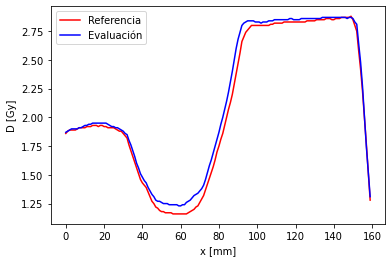

In [12]:
prf = 80
rv = sdf[prf]  # Vector de dosis de referencia
ev = smdf[prf] # Vector de dosis de evaluación

fig, ax = plt.subplots()

ax.plot(rv, 'r-', label='Referencia')
ax.plot(ev, 'b-', label='Evaluación')

ax.set_xlabel('x [mm]')
ax.set_ylabel('D [Gy]')
ax.legend()

plt.show()

Para hacer esta gráfica hemos explotado (sin explicarlo) que la separación espacial de los puntos medidos es 1 mm, por lo que no es necesario explicitar el vector de posiciones en el eje x. Lo sabemos leyendo la cabecera del archivo `dxf`. Para otros espaciados es necesario crear un vector de posiciones y representar la distribución en función de ella. 